/home/ekrem/Ekrem/chandrasekhar_solver.py:16: RuntimeWarning: invalid value encountered in double_scalars
  dydt = [y[1] , (-2/t)*y[1] - (y[0]**2 - (1/y_c**2))**(3/2)]


0 error: 2.743463648961576e-07  and corresponding D:  1710000000.0
1 error: 3.6527118675983414e-07  and corresponding D:  1720000000.0
2 error: 2.938561748742773e-07  and corresponding D:  1730000000.0
3 error: 3.3093604371474526e-07  and corresponding D:  1740000000.0
4 error: 2.468350220498787e-07  and corresponding D:  1750000000.0
5 error: 2.9401099688613414e-07  and corresponding D:  1760000000.0
6 error: 2.2510797418273134e-07  and corresponding D:  1770000000.0
7 error: 1.710877691133372e-07  and corresponding D:  1780000000.0
8 error: 1.1839436197030454e-07  and corresponding D:  1790000000.0
9 error: 7.877768109637209e-08  and corresponding D:  1800000000.0
10 error: 4.1777036536433274e-08  and corresponding D:  1810000000.0
11 error: 1.8467913842483757e-08  and corresponding D:  1820000000.0
12 error: 8.332282964906645e-09  and corresponding D:  1830000000.0
D is : 1830000000.0 with error:  2.1075048042135396e-09 corresponding C is:  5.380892404212922e+21


<Figure size 432x288 with 0 Axes>

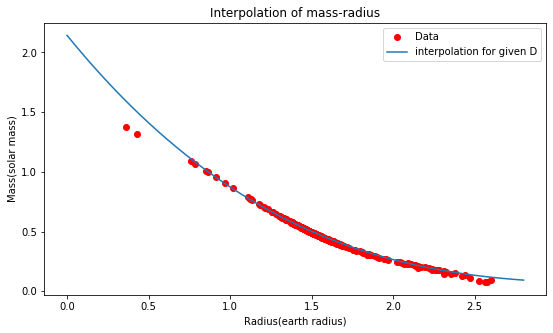

In [84]:
import numpy as np
import chandrasekhar_solver as ch
import Functions as F
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

### DATA ### 
M,logg = F.data_reader()
M,R = F.scaler(M,logg)

### inital guess ###
max_iter = 200
D = 1700000000.0
dD = 1e7
rho_c = np.linspace(10**10,10**7,20)
tol = 7e-9

### CONSTANTS(SI) ###
K = 3144530.473379261 #found before
G = 6.67408e-11
solar_mass = 1.988e30 #kg
earth_radius = 6.371e6 #m

zeta_n = 0 ## when the solution reaches surface value.
zeta_prime_n = 0 ## when the derivative reaches the surface
Radius = 0
Mass = 0
R_new = [] ## for storing new radius and mass
M_new = []


for i in range(max_iter):
        
   
    
    #D or rho_c dependent variables
    C = (5/8)*K*(D**(5/3))
    for rho in rho_c:
        ### solve the chandrasekhar for given rho and D ###
        sol,surface = ch.solve_chan(D,rho,limit=8.2,met='RK45')
        ##### find the surface #####
        for j in range(len(sol.t)):
            if (sol.y[0,j] <= surface):
                zeta_n = sol.t[j]
                zeta_prime_n = sol.y[1,j]
            elif(sol.y[0,-1]> surface):
                zeta_n = sol.t[-1]
                zeta_prime_n = sol.y[1,-1]
                


        #############################
        ### For Radius ###
        y_c = np.sqrt(rho/D + 1)
        Beta = np.sqrt((2*C)/(np.pi*G))/(D*y_c) ## scale factor of radius
        Radius = (Beta*zeta_n)
        ### For Mass ###
        Mass = 4*np.pi*(Radius**3)*D*(y_c**3)*(-zeta_prime_n/zeta_n)
        Mass = Mass/solar_mass
        Radius = Radius/earth_radius
        ## add them to array
        R_new.append(Radius)
        M_new.append(Mass)
    R_new = np.array(R_new)
    M_new = np.array(M_new)
    spl = UnivariateSpline(R_new, M_new)
    R_new = []
    M_new = []
    
    ### calculate error
    error=0
    for l in range(len(R)):
        error = error + (M[l]-spl(R[l]))**2
        error = error/(len(R))
    
    if (error < tol):
        print("D is :",D,"with error: ", error,"corresponding C is: ", C)
        x = np.linspace(0,2.8,500)
        plt.figure()
        fig, axis = plt.subplots(figsize = (9,5))
        plt.plot(R,M,'ro',x,spl(x))
        plt.title("Interpolation of mass-radius")
        plt.xlabel("Radius(earth radius)")
        plt.ylabel("Mass(solar mass)")
        plt.gca().legend(('Data','interpolation for given D'), loc='upper right')
        break;
      
    """CHECK FIT look if D is okay, if not update it """
    if (sum(M)-sum(spl(R))>0):
        D = D - dD
    else:
        D = D + dD      
    print(i,"error:",error," and corresponding D: ",D)
    error_ref = error
        